#### Importing needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.spatial import distance
import pygame
from pygame import gfxdraw
from copy import deepcopy
from collections import deque
from numpy.random import randint

pygame 2.0.1 (SDL 2.0.14, Python 3.8.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


## The intersection under consideration

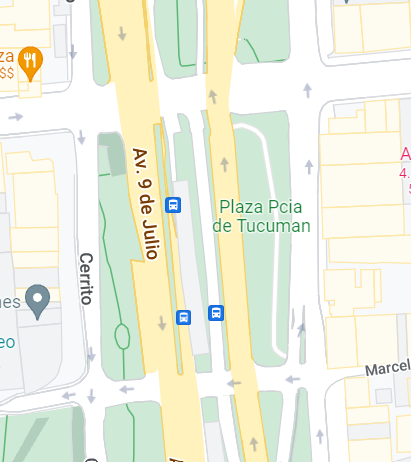

In [62]:
from IPython.display import Image
Image('maps_picture.png')

#### The approach

The approach is to use Cellular Automata by using a grid and defining parts of the grid to be roads. These roads are like conduction paths along which cars can travel. Paths will be randomly assigned to the cars upon them entering the road.

Coding approaches can be found explained in the code cells below. I will be including docstrings to help understand what each part of the code is doing. Class methods will not be included in the class docstring but rather in the method docstrings to make it easier for a non-coding audience to read through it.

In [2]:
class Road:
    '''
    A road class to define the parts of the grids that can be considerd roads
        
    Attributes
    ----------
        start: tuple
            starting point of the road
        end: tuple
            ending point of the road
        length: double
            euclidenan distance between the starting and ending points
        traffic_signal_present: Boolean
            indicator of whether road end has a traffic signal. Default value: False
        vehicles: double-ended queue
            keeps track of vehicles on the road to make sure. Deque is used for efficient appending and popping.
        density: int
            number of vehicles on a road. This can help check for traffic jams or possible needs for intervention.
        
    '''
    
    def __init__(self, starting, ending):
        self.start = starting
        self.end = ending 
        self.length = distance.euclidean(self.start, self.end) 
        self.traffic_signal_present = False
        self.vehicles = deque()
        self.density = len(self.vehicles)  
        self.angle_cos = (self.end[0] - self.start[0])/self.length
        self.angle_sin = (self.end[1] - self.start[1])/self.length

    def set_traffic_signal(self, signal, group):
        '''
        Method to set a traffic signal at the end of a road.
        
        Inputs:
            signal: object
                This is from the TrafficSignal class later on in the code and is used to make the signal.
            group: int
                This is the index for set of signals that our signal works in unison with to ensure smooth flow of traffic.
        '''
        self.traffic_signal = signal
        self.traffic_signal_group = group
        self.traffic_signal_present = True

    @property # can be used to retrieve properties later on in the code. Acts as a getter and setter method
    def traffic_signal_state(self):
        '''
        Method to check for the state of the signal
        '''
        # check if a traffic signal exists on the current road
        if self.traffic_signal_present:
            # set an integer value for the group
            i = self.traffic_signal_group
            # return whether the signal is red or green
            return self.traffic_signal.current_cycle[i]
        return True

    def update(self, dt):
        '''
        Updates the road conditions
        
        Inputs:
            dt: float
                difference in intervals for which the road is updated. Needed for velocity and accelration calculations.
        '''
        n = len(self.vehicles)
        # update road density
        self.density = n
        
        # if there are cars on the road
        if n > 0:
            # Update leading vehicle
            self.vehicles[0].update(None, dt)
            # Update rest
            for i in range(1, n):
                # find the vehicle ahead of the current one
                lead = self.vehicles[i-1]
                # update according to the vehicle ahead to avoid crashes
                self.vehicles[i].update(lead, dt)

            # Check for traffic signal state
            if self.traffic_signal_state:
                # Let vehicles through if it is green starting from lead and then the rest follow
                self.vehicles[0].unstop()
                for vehicle in self.vehicles:
                    vehicle.unslow()
            # if signal is red
            else:
                # if car's is outside the stopping zone
                if self.vehicles[0].x >= self.length - self.traffic_signal.slow_distance:
                    # Slow vehicle accordingly
                    self.vehicles[0].slow(self.traffic_signal.slow_factor*self.vehicles[0]._v_max)
                # if it is in the stop zone
                if self.vehicles[0].x >= self.length - self.traffic_signal.stop_distance and self.vehicles[0].x <= self.length - self.traffic_signal.stop_distance / 2:
                    # Stop the vehicle
                    self.vehicles[0].stop()

In [3]:
def curve_points(start, end, control, resolution=5):
    '''
    Function to define the points along which to make a curve
    
    Inputs:
        start: starting point of the curve
        end: ending point of the curve
        control: ensures smoothness of the curve
        resolution: number of smaller roads that the curve is built of
        
    Output:
        path: list of points that make up the curved road by combining together
    '''
    # If a straight road is passed, return it as is
    if (start[0] - end[0])*(start[1] - end[1]) == 0:
        return [start, end]

    # If not return a curve
    path = []
    
    # find the points of the shorter paths and append them to the path list
    for i in range(resolution+1):
        t = i/resolution
        x = (1-t)**2 * start[0] + 2*(1-t)*t * control[0] + t**2 *end[0]
        y = (1-t)**2 * start[1] + 2*(1-t)*t * control[1] + t**2 *end[1]
        path.append((x, y))

    return path

def curve_road(start, end, control, resolution=15):
    '''
    Function to make the curve from a set of points
    
    Inputs:
        start: starting point of the curve
        end: ending point of the curve
        control: smoothness control of the curve
        resolution: number of shorter roads that make up the curve to make it look smooth
    
    Outputs:
        list of points that can be passed to the Road class to make a curved road
    '''
    # find the points along which to define the curved road
    points = curve_points(start, end, control, resolution=resolution)
    return [(points[i-1], points[i]) for i in range(1, len(points))]

TURN_LEFT = 0
TURN_RIGHT = 1
def turn_road(start, end, turn_direction, resolution=15):
    '''
    Function to start definining the curve based on direction of turning
    
    Inputs:
        start: starting point of the curve
        end: ending point of the curve
        turn_direction: direction in which the car is turning
        resolution: number of shorter roads the curve will consist of
    '''
    # Get control point
    x = min(start[0], end[0])
    y = min(start[1], end[1])

    if turn_direction == TURN_LEFT:
        control = (
            x - y + start[1],
            y - x + end[0])
    else:
        control = (
            x - y + end[1],
            y - x + start[0])
    return curve_road(start, end, control, resolution=resolution)

In [4]:
class Vehicle:
    '''
    Vehicle class to define a blueprint for all the vehicles in our simulation
    
    Attributes
    ----------
        l: int
            length of the car
        s0: int
            minimum desired distance in between two cars
        T: float
            the reaction time of the driver
        v_max: float
            the maximum speed a car can go to
        a_max: float
            the maximum acceleration a car can have
        b_max: float
            the maximum deceleration a car can have
        path: list
            the list of roads that a car will travel during the simulation
        current_road_index: int
            the current road that the car is on
        x: int
            current position of the car on the grid
        v: float
            current speed of the car
        a: float
            current acceleration of the car
        stopped: Boolean
            Indicator of whether a car is moving or not
    '''
    
    def __init__(self, config={}):
        # Set default configuration unless otherwise specified
        self.set_default_config()

        # Update configuration
        for attr, val in config.items():
            setattr(self, attr, val)

        # Calculate properties
        # term to see how much distance there actually should be between the cars based on speed and decceleration
        self.sqrt_ab = 2*np.sqrt(self.a_max*self.b_max)
        # private python variable for the object which is the maximum speed of that particular car
        self._v_max = self.v_max

    def set_default_config(self): 
        '''
        Method to set the vehicle attributes. These can be changed if the person wants to account for various types of
        traffic e.g. changing length of cars accordinly to bring in bikes and trucks
        '''
        self.l = 4 #length of car
        self.s0 = 4 #minimum desired distance between cars
        self.T = 1
        self.v_max = 16.6
        self.a_max = 1.44
        self.b_max = 4.61

        self.path = []
        self.current_road_index = 0

        self.x = 0
        self.v = self.v_max
        self.a = 0
        self.stopped = False

    def update(self, lead, dt):
        '''
        Method to update the vehicle's position based on the car infront
        
        Inputs:
            lead: the car infront if any
            dt: time interval of the iterations
        '''
        # Update position and velocity
        # if new velocity is negative
        if self.v + self.a*dt < 0:
            # move the car a bit back and set velocity to 0
            self.x -= 1/2*self.v*self.v/self.a
            self.v = 0
        else:
            # update velocity according to acceleration
            self.v += self.a*dt
            # move the car forward by converting velocity and current acceleration to distance
            self.x += self.v*dt + self.a*dt*dt/2
        
        # Update acceleration
        # This model updates acceleration in a particular manner by first checking if the road is free or not
        # If the road is free, we have a positive acceleration
        # If there is another car on the road, acceleration is negative based on the current distance to the car
        
        
        alpha = 0
        # if there is a car infront
        if lead:
            # distance to the next car incorporating the length of the car as well
            delta_x = lead.x - self.x - lead.l
            # difference in speeds
            delta_v = self.v - lead.v
            # calculate acceleration coeffcient based on ratio of distances, speeds as well as account for reaction time
            alpha = (self.s0 + max(0, self.T*self.v + delta_v*self.v/self.sqrt_ab)) / delta_x
        
        # update acceleration
        self.a = self.a_max * (1-(self.v/self.v_max)**4 - alpha**2)
        
        # if the car is stationary
        if self.stopped: 
            # change acceleration to positive value based on previous velocity of the car
            self.a = -self.b_max*self.v/self.v_max
        
    def stop(self):
        '''Stop the car'''
        self.stopped = True

    def unstop(self):
        '''Start moving the car once stoppage has been removed'''
        self.stopped = False

    def slow(self, v):
        '''Slow down the car to a certain speed in the slowing down zones'''
        self.v_max = v

    def unslow(self):
        '''Start accelerating the car slowly when it starts moving to represent real life'''
        self.v_max += 0.1

In [5]:
class VehicleGenerator:
    '''
    Class to generate vehicles to feed into the simulation
    
    Attributes
    ----------
    
    sim: Simulation object
        current status of the simulation
    vehicle_rate: float
        rate at which vehicles arrive in the simulation
    vehicles: list
        list of all the vehicles along with their corresponding attributes
    last_added_time: float
        time when the last vehicle was added
    upcoming_vehicle: object
        Calls a method that returns a vehicle object to add to the simulation
    '''
    def __init__(self, sim, config={}):
        # set the simulation to current simulation to incorporate parameters
        self.sim = sim

        # Set default configurations unless otherwise specified
        self.set_default_config()

        # Update configurations if otherwise specified
        for attr, val in config.items():
            setattr(self, attr, val)

        self.init_properties()

    def set_default_config(self):
        '''Set default configuration. This can be changed based on rate of vehicle arrival'''
        self.vehicle_rate = 20
        self.vehicles = [
            (1, {})
        ]
        self.last_added_time = 0        

    def init_properties(self):
        self.upcoming_vehicle = self.generate_vehicle()
        
    def generate_vehicle(self):
        ''' Generates a random vehicle with its own attributes and adds it to the simulation'''
        # how many vehicles are there in the simulation right now
        total = sum(pair[0] for pair in self.vehicles)
        # pick a random weight to randomize generation
        r = randint(1, total+1)
        # since all vehicles are assigned paths on generation, it picks a path at random based on defined weights
        for (weight, config) in self.vehicles:
            r -= weight
            if r <= 0:
                return Vehicle(config)

    def update(self):
        '''Add vehicles to the simulation based on current conditions'''
        # check how much time has passed since last added vehicle
        if self.sim.t - self.last_added_time >= 60 / self.vehicle_rate:
            # If time is greater than generation rate, add another vehicle
            road = self.sim.roads[self.upcoming_vehicle.path[0]]
            # check for space to add vehicle
            if len(road.vehicles) == 0 or road.vehicles[-1].x > self.upcoming_vehicle.s0 + self.upcoming_vehicle.l:
                self.upcoming_vehicle.time_added = self.sim.t
                road.vehicles.append(self.upcoming_vehicle)
                # Reset last added time and upcoming vehicle
                self.last_added_time = self.sim.t
        self.upcoming_vehicle = self.generate_vehicle()

In [6]:
class TrafficSignal:
    '''
    Class to make traffic signals and update updating rules accordingly when one exists at the end of the road
    
    Attributes
    ----------
        roads: list 
            list of roads that the traffic signal is on
        cycle: list
            set of possible configurations based on number of traffic signals
        slow_distance: float
            distance from traffic signal that slowing zone starts
        slow_factor: float
            deceleration factor by which cars slow down in the slowing zone added on to the current acceleration
        stop_distance: float
            distance from the traffic signal the car must stop
        current_cycle_index: int
            current set of instructions
        last_t: float
            time that the last change happened at
        
    '''
    def __init__(self, roads, config={}):
        # Initialize roads
        self.roads = roads
        # Set default configuration unless otherwise specified
        self.set_default_config()
        # Update configuration if one given
        for attr, val in config.items():
            setattr(self, attr, val)
        # make traffic signals on the roads that have the attribute
        for i in range(len(self.roads)):
            for road in self.roads[i]:
                road.set_traffic_signal(self, i)

    def set_default_config(self):
        '''set default configuration if alternative is not given'''
        self.cycle = [(False, True), (True, False)]
        self.slow_distance = 50
        self.slow_factor = 0.4
        self.stop_distance = 15
        self.current_cycle_index = 0
        self.last_t = 0

    @property # this is where the useful part comes in as this allows for efficient communication between
              # the Road class and the Traffic Signal class when it has to check traffic signal conditions
    def current_cycle(self):
        '''set the cycle to the corresponding index'''
        return self.cycle[self.current_cycle_index]
    
    def update(self, sim):
        '''update the traffic lights based on division'''
        # sampled traffic lights changed every 30 seconds on both roads. You can change this
        cycle_length = 30
        # divide current time by cycle_length to find the remainder
        k = (sim.t // cycle_length) % 2
        # set corresponding index to the current cycle. Alternates between the signals
        self.current_cycle_index = int(k)

In [7]:
class Simulation:
    '''
    Class to run the simulation. This class brings everything together
    
    Attributes
    ----------
        density: list
            how is the density of the system changing over time
        t : float
            current time in the simulation
        frame_count: int
            keeping track of iterations
        dt: float
            interval of iterations or timesteps
        roads: list
            list of roads in the simulation
        generators: list
            list of vehicle generators that will supply the simulation
        traffic_signals: list
            list of traffic signals in the simulation
    '''
    def __init__(self, config={}):
        # Set default configuration unless otherwise specified
        self.set_default_config()
        # Update configuration if one is given
        for attr, val in config.items():
            setattr(self, attr, val)
        self.density = []

    def set_default_config(self):
        '''Set the default configuration'''
        self.t = 0.0            
        self.frame_count = 0    
        self.dt = 1/60          
        self.roads = []         
        self.generators = []
        self.traffic_signals = []

    def create_road(self, start, end):
        '''create road objects and appends them to the list of roads'''
        road = Road(start, end)
        self.roads.append(road)
        return road

    def create_roads(self, road_list):
        '''generate curves if needed'''
        for road in road_list:
            self.create_road(*road)

    def create_gen(self, config={}):
        '''make vehicle generators and append them to the list of generators'''
        gen = VehicleGenerator(self, config)
        self.generators.append(gen)
        return gen

    def create_signal(self, roads, config={}):
        '''make the traffic signals in the simulation'''
        roads = [[self.roads[i] for i in road_group] for road_group in roads]
        sig = TrafficSignal(roads, config)
        self.traffic_signals.append(sig)
        return sig

    
    def update(self):
        '''Update step of every iteration'''
        # Update every road in the system
        for road in self.roads:
            road.update(self.dt)

        # Add vehicles to the system
        for gen in self.generators:
            gen.update()
            
        # update every signal in the system
        for signal in self.traffic_signals:
            signal.update(self)
        
        # density counter
        density = 0
        # Check roads for out of bounds vehicle
        for road in self.roads:
            density += len(road.vehicles)
            if len(road.vehicles) > 1:
                # make sure that no vehicles are very close together
                for v in range(1, len(road.vehicles)): 
                    if road.vehicles[v].x > road.vehicles[-1].s0 + road.vehicles[-1].l:
                        # if they are close together, slow down the vehicle
                        road.vehicles[v].slow(0.5*road.vehicles[v]._v_max)
                    else:
                        # let the current vehicle accelerate
                        road.vehicles[v].unslow()
            # Empty roads, skip iteration
            if len(road.vehicles) == 0: 
                continue
            # If roads are not empty
            vehicle = road.vehicles[0]
            # If vehicle has traversed the current road
            if vehicle.x >= road.length:
                # check if it has to go another road in its path
                if vehicle.current_road_index + 1 < len(vehicle.path):
                    # Update current road to next road
                    vehicle.current_road_index += 1
                    # As vehicles are not single cells, flipping the road is hard. Instead, we make copies and
                    # intialize them on the next road to simulate the change
                    new_vehicle = deepcopy(vehicle)
                    new_vehicle.x = 0
                    next_road_index = vehicle.path[vehicle.current_road_index]
                    self.roads[next_road_index].vehicles.append(new_vehicle)
                    
                # Remove it from the current road
                road.vehicles.popleft() 
        # Append density of the entire system to the list
        self.density.append(density)    
        # Time increment
        self.t += self.dt
        self.frame_count += 1


    def run(self, steps):
        '''run the simulation for given steps before displaying new update'''
        for _ in range(steps):
            self.update()

In [8]:
# Code adapted from https://github.com/BilHim/trafficSimulator/blob/main/src/trafficSimulator/window.py
class Window:
    '''
    This is a class to show the simulation visually to the audience by generating a pygame window.
    
    Attributes
    ----------
        sim: object
            The current simulation that it is representing
        width:
            width of the window
        height:
            height of the window
        bg_color:
            set of colors
        fps:
            frames displayed per second
        zoom:
            zoom into and out of the window
        offset:
            centering your simulation to the window
            
    Understanding this class is not important past the first couple of methods. The rest is a lot about
    the drawing that pygame is doing in the background which can be ignored for the most part.
    If you want to add something i.e. a shape you can't find here, please follow pygame documentation linked
    here: https://www.pygame.org/docs/
    Or if you have some coding experience, you can try to replicate the code from the other shapes
    '''
    def __init__(self, sim, config={}):
        # Simulation to draw
        self.sim = sim

        # Set default configurations unless specified
        self.set_default_config()

        # Update configurations if one is given
        for attr, val in config.items():
            setattr(self, attr, val)
        
    def set_default_config(self):
        '''Set default configuration'''
        self.width = 900
        self.height = 600
        self.bg_color = (250, 250, 250)

        self.fps = 60
        self.zoom = 5
        self.offset = (0, 0)

        self.mouse_last = (0, 0)
        self.mouse_down = False


    def loop(self, loop=None):
        """Shows a window visualizing the simulation and runs the loop function."""
        
        # Create a pygame window
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.flip()
        # Fixed fps
        clock = pygame.time.Clock()
        # text
        pygame.font.init()
        self.text_font = pygame.font.SysFont('Arial', 20)

        # Display loop
        running = True
        while running:
            # Update simulation
            if loop: 
                loop(self.sim)

            # Display simulation
            self.draw()

            # Update window
            pygame.display.update()
            # update time
            clock.tick(self.fps) 

            # Do all events
            for event in pygame.event.get():
                # Quit program if window is closed
                if event.type == pygame.QUIT:
                    running = False
                    pygame.quit()
                # Handle mouse events
                elif event.type == pygame.MOUSEBUTTONDOWN:
                    # If mouse button down
                    if event.button == 1:
                        # Left click
                        x, y = pygame.mouse.get_pos()
                        x0, y0 = self.offset
                        self.mouse_last = (x-x0*self.zoom, y-y0*self.zoom)
                        self.mouse_down = True
                    if event.button == 4:
                        # Mouse wheel up
                        self.zoom *=  (self.zoom**2+self.zoom/4+1) / (self.zoom**2+1)
                    if event.button == 5:
                        # Mouse wheel down 
                        self.zoom *= (self.zoom**2+1) / (self.zoom**2+self.zoom/4+1)
                elif event.type == pygame.MOUSEMOTION:
                    # Drag content
                    if self.mouse_down:
                        x1, y1 = self.mouse_last
                        x2, y2 = pygame.mouse.get_pos()
                        self.offset = ((x2-x1)/self.zoom, (y2-y1)/self.zoom)
                elif event.type == pygame.MOUSEBUTTONUP:
                    self.mouse_down = False           

    def run(self, steps_per_update=1):
        """Runs the simulation by updating in every loop."""
        def loop(sim):
            sim.run(steps_per_update)
        self.loop(loop)

    def convert(self, x, y=None):
        """Converts simulation coordinates to screen coordinates"""
        if isinstance(x, list):
            return [self.convert(e[0], e[1]) for e in x]
        if isinstance(x, tuple):
            return self.convert(*x)
        return (
            int(self.width/2 + (x + self.offset[0])*self.zoom),
            int(self.height/2 + (y + self.offset[1])*self.zoom)
        )

    def inverse_convert(self, x, y=None):
        """Converts screen coordinates to simulation coordinates"""
        if isinstance(x, list):
            return [self.convert(e[0], e[1]) for e in x]
        if isinstance(x, tuple):
            return self.convert(*x)
        return (
            int(-self.offset[0] + (x - self.width/2)/self.zoom),
            int(-self.offset[1] + (y - self.height/2)/self.zoom)
        )


    def background(self, r, g, b):
        """Fills screen with one color."""
        self.screen.fill((r, g, b))

    def line(self, start_pos, end_pos, color):
        """Draws a line."""
        gfxdraw.line(
            self.screen,
            *start_pos,
            *end_pos,
            color
        )

    def rect(self, pos, size, color):
        """Draws a rectangle."""
        gfxdraw.rectangle(self.screen, (*pos, *size), color)

    def box(self, pos, size, color):
        """Draws a rectangle."""
        gfxdraw.box(self.screen, (*pos, *size), color)

    def circle(self, pos, radius, color, filled=True):
        gfxdraw.aacircle(self.screen, *pos, radius, color)
        if filled:
            gfxdraw.filled_circle(self.screen, *pos, radius, color)



    def polygon(self, vertices, color, filled=True):
        gfxdraw.aapolygon(self.screen, vertices, color)
        if filled:
            gfxdraw.filled_polygon(self.screen, vertices, color)

    def rotated_box(self, pos, size, angle=None, cos=None, sin=None, centered=True, color=(0, 0, 255), filled=True):
        """Draws a rectangle center at *pos* with size *size* rotated anti-clockwise by *angle*."""
        x, y = pos
        l, h = size

        if angle:
            cos, sin = np.cos(angle), np.sin(angle)
        
        vertex = lambda e1, e2: (
            x + (e1*l*cos + e2*h*sin)/2,
            y + (e1*l*sin - e2*h*cos)/2
        )

        if centered:
            vertices = self.convert(
                [vertex(*e) for e in [(-1,-1), (-1, 1), (1,1), (1,-1)]]
            )
        else:
            vertices = self.convert(
                [vertex(*e) for e in [(0,-1), (0, 1), (2,1), (2,-1)]]
            )

        self.polygon(vertices, color, filled=filled)

    def rotated_rect(self, pos, size, angle=None, cos=None, sin=None, centered=True, color=(0, 0, 255)):
        self.rotated_box(pos, size, angle=angle, cos=cos, sin=sin, centered=centered, color=color, filled=False)

    def arrow(self, pos, size, angle=None, cos=None, sin=None, color=(150, 150, 190)):
        if angle:
            cos, sin = np.cos(angle), np.sin(angle)
        
        self.rotated_box(
            pos,
            size,
            cos=(cos - sin) / np.sqrt(2),
            sin=(cos + sin) / np.sqrt(2),
            color=color,
            centered=False
        )

        self.rotated_box(
            pos,
            size,
            cos=(cos + sin) / np.sqrt(2),
            sin=(sin - cos) / np.sqrt(2),
            color=color,
            centered=False
        )


    def draw_axes(self, color=(100, 100, 100)):
        x_start, y_start = self.inverse_convert(0, 0)
        x_end, y_end = self.inverse_convert(self.width, self.height)
        self.line(
            self.convert((0, y_start)),
            self.convert((0, y_end)),
            color
        )
        self.line(
            self.convert((x_start, 0)),
            self.convert((x_end, 0)),
            color
        )

    def draw_grid(self, unit=50, color=(150,150,150)):
        x_start, y_start = self.inverse_convert(0, 0)
        x_end, y_end = self.inverse_convert(self.width, self.height)

        n_x = int(x_start / unit)
        n_y = int(y_start / unit)
        m_x = int(x_end / unit)+1
        m_y = int(y_end / unit)+1

        for i in range(n_x, m_x):
            self.line(
                self.convert((unit*i, y_start)),
                self.convert((unit*i, y_end)),
                color
            )
        for i in range(n_y, m_y):
            self.line(
                self.convert((x_start, unit*i)),
                self.convert((x_end, unit*i)),
                color
            )

    def draw_roads(self):
        for road in self.sim.roads:
            # Draw road background
            self.rotated_box(
                road.start,
                (road.length, 10),
                cos=road.angle_cos,
                sin=road.angle_sin,
                color=(180, 180, 220),
                centered=False
            )

            # Draw road arrow
            if road.length > 5: 
                for i in np.arange(-0.5*road.length, 0.5*road.length, 10):
                    pos = (
                        road.start[0] + (road.length/2 + i + 3) * road.angle_cos,
                        road.start[1] + (road.length/2 + i + 3) * road.angle_sin
                    )

                    self.arrow(
                        pos,
                        (-1.25, 0.2),
                        cos=road.angle_cos,
                        sin=road.angle_sin
                    )   

    def draw_vehicle(self, vehicle, road):
        l, h = vehicle.l,  2
        sin, cos = road.angle_sin, road.angle_cos

        x = road.start[0] + cos * vehicle.x 
        y = road.start[1] + sin * vehicle.x 

        self.rotated_box((x, y), (l, h), cos=cos, sin=sin, centered=True)

    def draw_vehicles(self):
        for road in self.sim.roads:
            # Draw vehicles
            for vehicle in road.vehicles:
                self.draw_vehicle(vehicle, road)

    def draw_signals(self):
        for signal in self.sim.traffic_signals:
            for i in range(len(signal.roads)):
                color = (0, 255, 0) if signal.current_cycle[i] else (255, 0, 0)
                for road in signal.roads[i]:
                    a = 0
                    position = (
                        (1-a)*road.end[0] + a*road.start[0],        
                        (1-a)*road.end[1] + a*road.start[1]
                    )
                    self.rotated_box(
                        position,
                        (1, 3),
                        cos=road.angle_cos, sin=road.angle_sin,
                        color=color)

    def draw_status(self):
        text_fps = self.text_font.render(f't={self.sim.t:.5}', False, (0, 0, 0))
        text_frc = self.text_font.render(f'n={self.sim.frame_count}', False, (0, 0, 0))
        
        self.screen.blit(text_fps, (0, 0))
        self.screen.blit(text_frc, (100, 0))


    def draw(self):
        # Fill background
        self.background(*self.bg_color)

        # Major and minor grid and axes
        # self.draw_grid(10, (220,220,220))
        # self.draw_grid(100, (200,200,200))
        # self.draw_axes()

        self.draw_roads()
        self.draw_vehicles()
        self.draw_signals()

        # Draw status info
        self.draw_status()

In [9]:
class Empirics:
    '''
    Class to run the simulation for longer runs in order to do analyses
    
    Attributes
    ----------
        fps:
            frames per second
        running: Boolean
            is the simulation runnning or not
    '''
    def __init__(self, sim, config={}):
        # Simulation to work with
        self.sim = sim

        # Set default configurations
        self.set_default_config()

        # Update configurations if specified
        for attr, val in config.items():
            setattr(self, attr, val)
        
    def set_default_config(self):
        """Set default configuration"""
        self.fps = 60
        self.running = True

    def loop(self, loop=None, trials = 1):
        """runs the loop function."""

        # Fixed fps
        clock = pygame.time.Clock()
        running = self.running
        for i in range(trials):
            # Update simulation
            if loop: loop(self.sim)
            clock.tick(self.fps)         

    def run(self, steps_per_update=1, trials = 100):
        """Runs the simulation by updating in every loop for a set number of trials"""
        def loop(sim):
            sim.run(steps_per_update)
        for i in range(trials):
            self.loop(loop)
        self.running = False

In [13]:
# this is the original version of the road that I have modelled
sim_1 = Simulation()

# variables
a = 10
b = 20
l = 300

# Road edge coordinates for easy scaling
WRS = (-b-l, a)
WLS = (-b-l, -a)
SRS = (a, b+l)
SLS = (-a, b+l)
ERS = (b+l, -a)
ELS = (b+l, a)
NRS = (-a, -b-l)
NLS = (a, -b-l)
WR = (-b, a)
WL = (-b, -a)
SR = (a, b)
SL = (-a, b)
ER = (b, -a)
EL = (b, a)
NR = (-a, -b)
NL = (a, -b)

# Roads
WEST_IN = (WRS, WR)
SOUTH_IN = (SRS, SR)
EAST_IN = (ERS, ER)
NORTH_IN = (NRS, NR)

WEST_OUT = (WL, WLS)
SOUTH_OUT = (SL, SLS)
EAST_OUT = (EL, ELS)
NORTH_OUT = (NL, NLS)

WEST_STRAIGHT = (WR, EL)
SOUTH_STRAIGHT = (SR, NL)
EAST_STRAIGHT = (ER, WL)
NORTH_STRAIGHT = (NR, SL)

n = 15 # resolution
WEST_RIGHT_TURN = turn_road(WR, SL, TURN_RIGHT, n)
SOUTH_RIGHT_TURN = turn_road(SR, EL, TURN_RIGHT, n)
EAST_RIGHT_TURN = turn_road(ER, NL, TURN_RIGHT, n)
NORTH_RIGHT_TURN = turn_road(NR, WL, TURN_RIGHT, n)

model = [WEST_IN, SOUTH_IN, EAST_IN, NORTH_IN, WEST_OUT, SOUTH_OUT, EAST_OUT, NORTH_OUT, WEST_STRAIGHT, 
         SOUTH_STRAIGHT, EAST_STRAIGHT, NORTH_STRAIGHT, *WEST_RIGHT_TURN, *SOUTH_RIGHT_TURN, *EAST_RIGHT_TURN, 
         *NORTH_RIGHT_TURN, ]

sim_1.create_roads(model)

def road(a): 
    return range(a, a+n)

sim_1.create_gen({
'vehicle_rate': 30,
'vehicles':[
    [3, {'path': [0, 8, 6]}],
    [1, {'path': [0, *road(12), 5]}],

    [3, {'path': [1, 9, 7]}],
    [1, {'path': [1, *road(12+n), 6]}],

    [3, {'path': [2, 10, 4]}],
    [1, {'path': [2, *road(12+2*n), 7]}],

    [3, {'path': [3, 11, 5]}],
    [1, {'path': [3, *road(12+3*n), 4]}],
]})

sim_1.create_signal([[0, 2], [1, 3]])

#sim.run(steps = 100)
# Start simulation
win = Window(sim_1)
win.zoom = 3
win.run(steps_per_update=10)

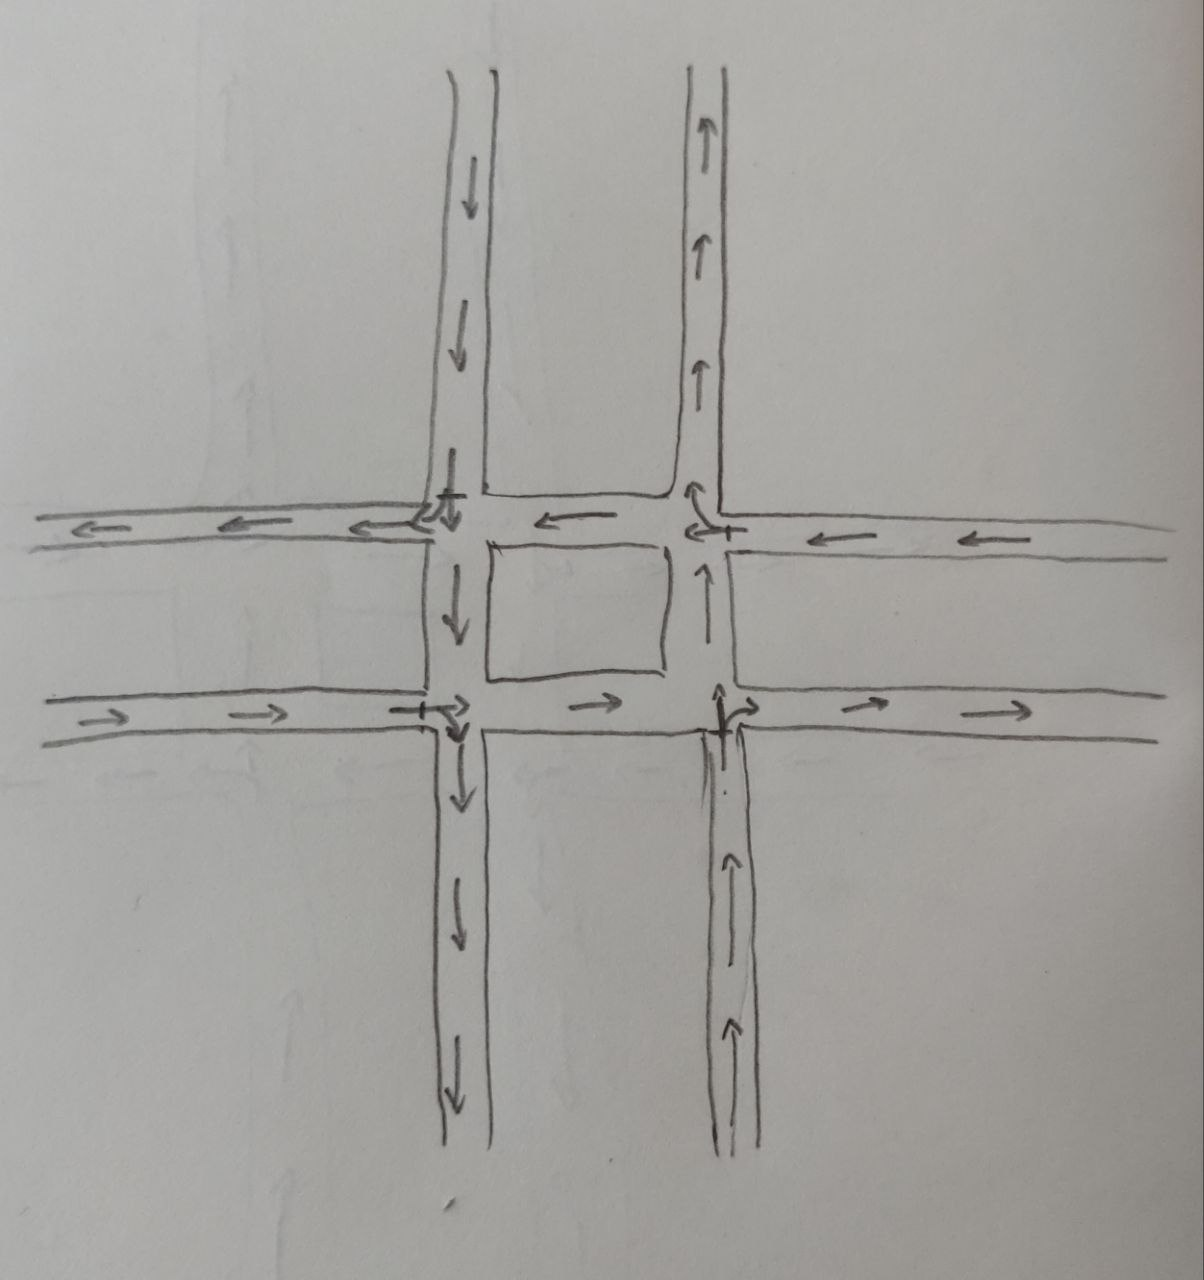

In [63]:
from IPython.display import Image
Image('current_version.jpg')

In [28]:
# this is the original version of the road that I have modelled
sim_2 = Simulation()

sim_2.create_roads(model)

def road(a): return range(a, a+n)

sim_2.create_gen({
'vehicle_rate': 30,
'vehicles':[
    [3, {'path': [0, 8, 6]}],
    [1, {'path': [0, *road(12), 5]}],

    [3, {'path': [1, 9, 7]}],
    [1, {'path': [1, *road(12+n), 6]}],

    [3, {'path': [2, 10, 4]}],
    [1, {'path': [2, *road(12+2*n), 7]}],

    [3, {'path': [3, 11, 5]}],
    [1, {'path': [3, *road(12+3*n), 4]}],
]})

sim_2.create_signal([[0, 2], [1, 3]])

#sim.run(steps = 100)
# Start simulation
win = Empirics(sim_2)
win.run(steps_per_update=10, trials = 5000)

In [29]:
len(sim_2.density)

50000

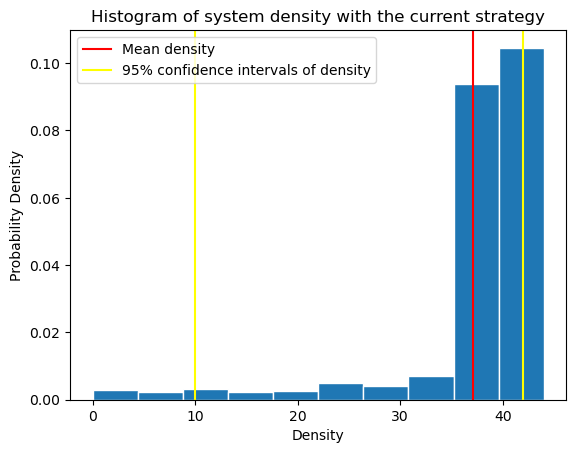

Mean density of the new strategy: 37.09054
95% confidence interval of the density: [10. 42.]


In [52]:
plt.figure()
y = sim_2.density
mean_1 = np.mean(y)
confint_1 = np.quantile(y, (0.025, 0.975))
plt.hist(y, bins = 10, edgecolor = 'white', density = True, color = 'blue')
plt.axvline(mean_1, label = 'Mean density', color = 'red')
plt.axvline(confint_1[0], color = 'yellow', label = '95% confidence intervals of density')
plt.axvline(confint_1[1], color = 'yellow')
plt.hist(sim_2.density, bins = 10, edgecolor = 'white', density = True)
plt.title('Histogram of system density with the current strategy')
plt.xlabel('Density')
plt.ylabel('Probability Density')
plt.legend()
plt.show()
print(f'Mean density of the new strategy: {mean_1}')
print(f'95% confidence interval of the density: {confint_1}')

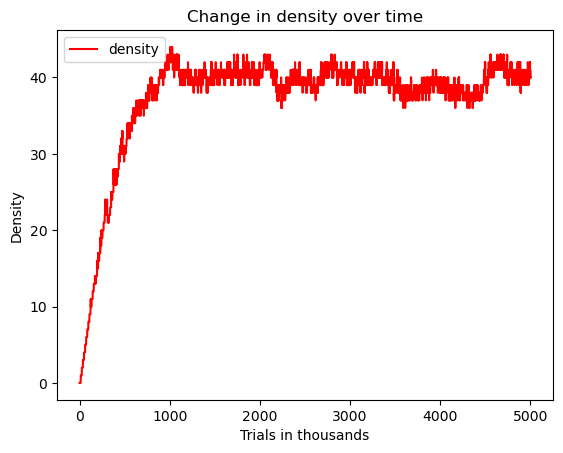

In [61]:
plt.figure()
y = sim_2.density
x = np.linspace(0, 5000, len(y))
plt.plot(x, y, label = 'density', color = 'red')
plt.title('Change in density over time')
plt.xlabel('Trials in thousands')
plt.ylabel('Density')
plt.legend()
plt.show()

In [32]:
sim_3 = Simulation()

# Roads
WEST_INBOUND = ((-40,180), (30,180))
SOUTH_INBOUND = ((120,300), (120,210))
EAST_INBOUND = ((220,120), (150,120))
NORTH_INBOUND = ((60,0), (60,90))

WEST_SIGNAL = ((30,180), (55,180))
SOUTH_SIGNAL = ((120,220),(120,185))
EAST_SIGNAL = ((150,120), (125,120))
NORTH_SIGNAL = ((60,90), (60,115))

WEST_OUTBOUND = ((30,120), (-40,120))
SOUTH_OUTBOUND = ((60,210), (60,300))
EAST_OUTBOUND = ((150,180), (220,180))
NORTH_OUTBOUND = ((120,90), (120,0))

WEST_STRAIGHT = ((60,180), (150,180))
SOUTH_STRAIGHT = ((60,120), (60,210))
EAST_STRAIGHT = ((120,120), (30,120))
NORTH_STRAIGHT = ((120,180), (120,90))

RIGHT_UPHANDER = ((160,120), (120,80))
DOWN_RIGHTHANDER = ((120,220), (160,180))
LEFT_DOWNHANDER = ((20,180), (60,220))
UP_RIGHTHANDER = ((60,80), (20,120))

sim_3.create_roads([
    WEST_INBOUND, #0
    SOUTH_INBOUND, #1
    EAST_INBOUND, #2
    NORTH_INBOUND, #3

    WEST_OUTBOUND, #4
    SOUTH_OUTBOUND, #5 
    EAST_OUTBOUND, #6
    NORTH_OUTBOUND, #7

    WEST_STRAIGHT, #8
    SOUTH_STRAIGHT, #9 
    EAST_STRAIGHT, #10
    NORTH_STRAIGHT, #11
    
    RIGHT_UPHANDER, #12
    DOWN_RIGHTHANDER, #13
    UP_RIGHTHANDER, #14
    LEFT_DOWNHANDER, #15 
    
    WEST_SIGNAL, #16
    EAST_SIGNAL, #17
    SOUTH_SIGNAL, #18
    NORTH_SIGNAL # 19
])

sim_3.create_gen({
'vehicle_rate': 30,
'vehicles':[
    [3, {'path': [0, 16, 8, 6]}],
    [1, {'path': [0, 15, 5]}],

    [3, {'path': [1, 18, 11, 7]}],
    [1, {'path': [1, 13, 6]}],

    [3, {'path': [2, 17, 10, 4]}],
    [1, {'path': [2, 12, 7]}],

    [3, {'path': [3, 17, 9, 5]}],
    [1, {'path': [3, 14, 4]}],
]})

sim_3.create_signal([[16, 17], [18, 19]])

#sim.run(steps = 100)
# Start simulation
win = Empirics(sim_3)
win.zoom = 3
win.run(steps_per_update=10, trials = 5000)

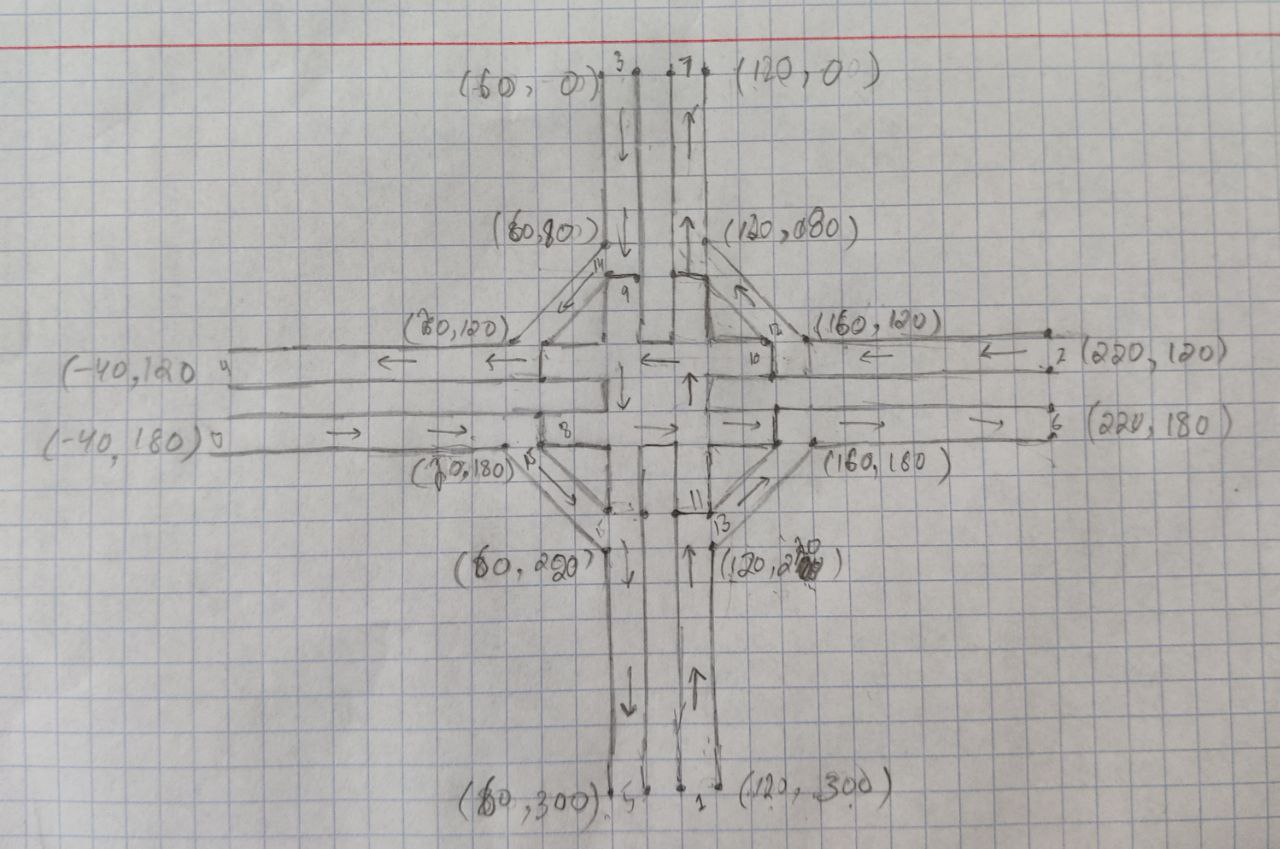

In [64]:
from IPython.display import Image
Image('proposed_version.jpg')

In [33]:
len(sim_3.density)

50000

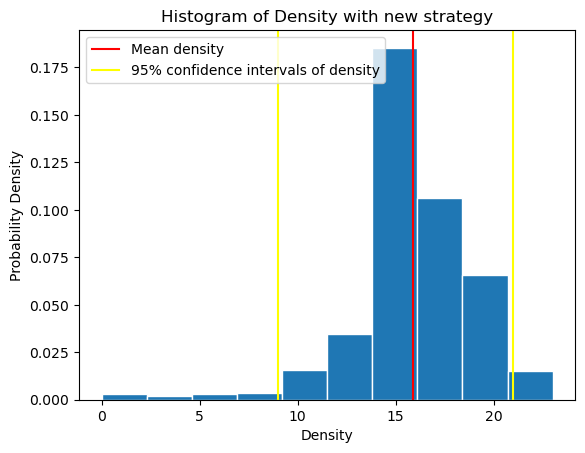

Mean density of the new strategy: 15.87916
95% confidence interval of the density: [ 9. 21.]


In [60]:
plt.figure()
y = sim_3.density
mean_2 = np.mean(y)
confint_2 = np.quantile(y, (0.025, 0.975))
plt.hist(y, bins = 10, edgecolor = 'white', density = True)
plt.axvline(mean_2, label = 'Mean density', color = 'red')
plt.axvline(confint_2[0], color = 'yellow', label = '95% confidence intervals of density')
plt.axvline(confint_2[1], color = 'yellow')
plt.xlabel('Density')
plt.ylabel('Probability Density')
plt.title('Histogram of Density with new strategy')
plt.legend()
plt.show()
print(f'Mean density of the new strategy: {mean_2}')
print(f'95% confidence interval of the density: {confint_2}')

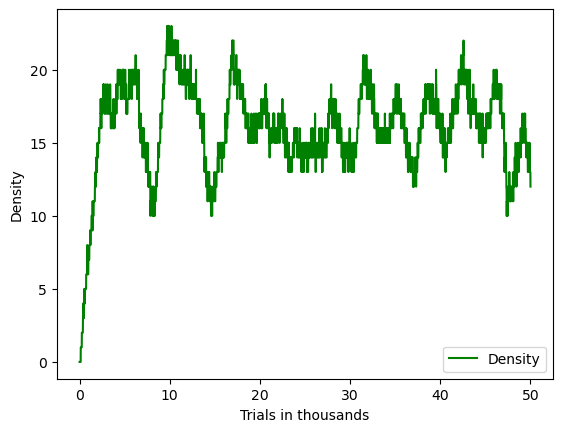

In [54]:
plt.figure()
y = sim_3.density
x = np.linspace(0, 50, len(y))
plt.plot(x, y, label = 'Density', color = 'green')
plt.xlabel('Trials in thousands')
plt.ylabel('Density')
plt.legend()
plt.show()

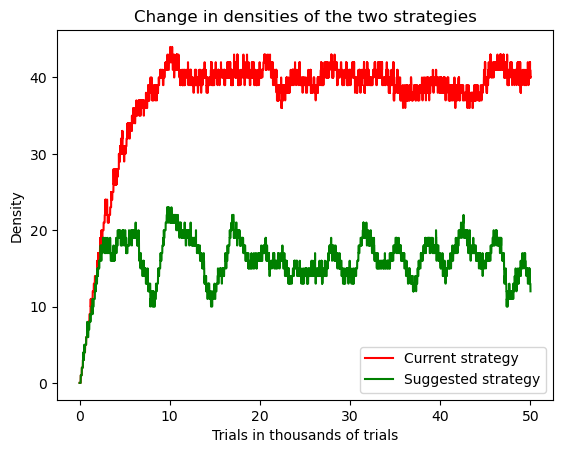

In [55]:
plt.figure()
current = sim_2.density
new = sim_3.density
x = np.linspace(0, len(current)/1000, len(current))
plt.plot(x, current, color = 'red', label = 'Current strategy')
plt.plot(x, new, color = 'green', label = 'Suggested strategy')
plt.xlabel('Trials in thousands of trials')
plt.ylabel('Density')
plt.title('Change in densities of the two strategies')
plt.legend()
plt.show()

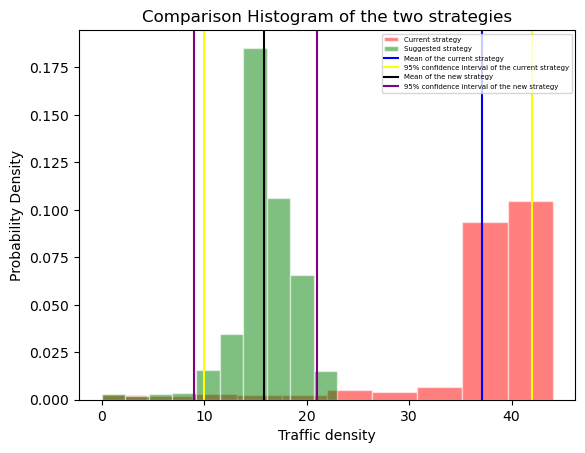

In [59]:
plt.figure()
current = sim_2.density
new = sim_3.density
x = np.linspace(0, 20, 20000)
plt.hist(current, edgecolor = 'white', bins = 10, color = 'red', label = 'Current strategy', alpha = 0.5, density = True)
plt.hist(new, edgecolor = 'white', bins = 10, color = 'green', label = 'Suggested strategy', alpha = 0.5, density = True)
plt.axvline(mean_1, color = 'blue', label = 'Mean of the current strategy')
plt.axvline(confint_1[0], color = 'yellow', label = '95% confidence interval of the current strategy')
plt.axvline(confint_1[1], color = 'yellow')
plt.axvline(mean_2, color = 'black', label = 'Mean of the new strategy')
plt.axvline(confint_2[0], color = 'purple', label = '95% confidence interval of the new strategy')
plt.axvline(confint_2[1], color = 'purple')
plt.xlabel('Traffic density')
plt.ylabel('Probability Density')
plt.title('Comparison Histogram of the two strategies')
plt.legend(fontsize = 5)
plt.show()

In [88]:
# sim_4 = Simulation()

# # Roads
# WEST_INBOUND = ((-40,180), (30,180))
# SOUTH_INBOUND = ((120,300), (120,210))
# EAST_INBOUND = ((220,120), (150,120))
# NORTH_INBOUND = ((60,0), (60,90))

# WEST_SIGNAL = ((30,180), (55,180))
# SOUTH_SIGNAL = ((120,220),(120,185))
# EAST_SIGNAL = ((150,120), (125,120))
# NORTH_SIGNAL = ((60,90), (60,115))

# WEST_OUTBOUND = ((30,120), (-40,120))
# SOUTH_OUTBOUND = ((60,210), (60,300))
# EAST_OUTBOUND = ((150,180), (220,180))
# NORTH_OUTBOUND = ((120,90), (120,0))

# WEST_STRAIGHT = ((60,180), (150,180))
# SOUTH_STRAIGHT = ((60,120), (60,210))
# EAST_STRAIGHT = ((120,120), (30,120))
# NORTH_STRAIGHT = ((120,180), (120,90))

# # RIGHT_UPHANDER = ((160,120), (120,80))
# # DOWN_RIGHTHANDER = ((120,220), (160,180))
# # LEFT_DOWNHANDER = ((20,180), (60,220))
# # UP_RIGHTHANDER = ((60,80), (20,120))

# RIGHT_UPHANDER = turn_road((160,120), (120,80), TURN_RIGHT, n)
# DOWN_RIGHTHANDER = turn_road((120,220), (160,180), TURN_RIGHT, n)
# LEFT_DOWNHANDER= turn_road((20,180), (60,220), TURN_RIGHT, n)
# UP_RIGHTHANDER = turn_road((60,80), (20,120), TURN_RIGHT, n)


# sim_4.create_roads([
#     WEST_INBOUND, #0
#     SOUTH_INBOUND, #1
#     EAST_INBOUND, #2
#     NORTH_INBOUND, #3

#     WEST_OUTBOUND, #4
#     SOUTH_OUTBOUND, #5 
#     EAST_OUTBOUND, #6
#     NORTH_OUTBOUND, #7

#     WEST_STRAIGHT, #8
#     SOUTH_STRAIGHT, #9 
#     EAST_STRAIGHT, #10
#     NORTH_STRAIGHT, #11
    
#     WEST_SIGNAL, # 12
#     EAST_SIGNAL, # 13
#     SOUTH_SIGNAL, # 14
#     NORTH_SIGNAL, # 15

#     *RIGHT_UPHANDER, # 16
#     *DOWN_RIGHTHANDER, #16+n
#     *UP_RIGHTHANDER, #16+2n
#     *LEFT_DOWNHANDER  #16+3n

# ])

# sim_4.create_gen({
# 'vehicle_rate': 30,
# 'vehicles':[
#     [0, {'path': [0, 16, 8, 6]}],
#     [1, {'path': [0, *road(16 + 3*n), 5]}],

#     [0, {'path': [1, 18, 11, 7]}],
#     [1, {'path': [1, *road(16 + n), 6]}],

#     [0, {'path': [2, 17, 10, 4]}],
#     [1, {'path': [2, *road(16), 7]}],

#     [0, {'path': [3, 17, 9, 5]}],
#     [1, {'path': [3, *road(16 + 2*n), 4]}],
# ]})

# sim_4.create_signal([[12, 13], [14, 15]])

# #sim.run(steps = 100)
# # Start simulation
# win = Window(sim_4)
# win.offset = (-90, -150)
# win.zoom = 3
# win.run(steps_per_update=3)